In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/N/slate/qmnguyen/projects/future-sst-prediction-diffusion


In [2]:
from __future__ import annotations

import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import xarray as xr

# SST Statistics of Each Patch

In this experiment,
I will look at the statistics of each patch in each year.

In [3]:
class PatchDataset:
    def __init__(self, patch: int, year: int | None = None) -> None:
        self._patches = self._load_patches(patch, year)

    def __len__(self):
        return self._patches.shape[0]

    def __getitem__(self, idx):
        return self._patches[idx]

    def __iter__(self):
        for i in range(len(self)):
            yield self[i]

    def _load_patches(self, path: int, year: int | None) -> np.ndarray:
        files = PatchDataset._list_files(path, year)

        patches = []
        for file in files:
            ds = xr.load_dataset(file, engine='netcdf4')
            patches.append(ds['sst'].values)

        return np.concatenate(patches, axis=0)

    @staticmethod
    def _list_files(patch: int, year: int | None):
        filename_pattern = f"sst.day.mean.{'*' if year is None else year}.patch_{patch:0>2}.nc"
        full_path_pattern = os.path.join('NOAA/OI_SST_v2_patches', filename_pattern)
        return sorted(glob.glob(full_path_pattern))


def min_temp(ds: PatchDataset):
    temp = np.inf
    for patch in iter(ds):
        min_temp = patch.min()
        if min_temp < temp:
            temp = min_temp

    return temp


def max_temp(ds: PatchDataset):
    temp = -np.inf
    for patch in iter(ds):
        max_temp = patch.max()
        if max_temp > temp:
            temp = max_temp

    return temp


def mean_temp(ds: PatchDataset):
    temp = [p.mean() for p in iter(ds)]
    return sum(temp) / len(ds)


ds = PatchDataset(1, 2006)
print(min_temp(ds), max_temp(ds), mean_temp(ds))

15.17 29.21 22.811578834220153


## Statistics of each patch in each year

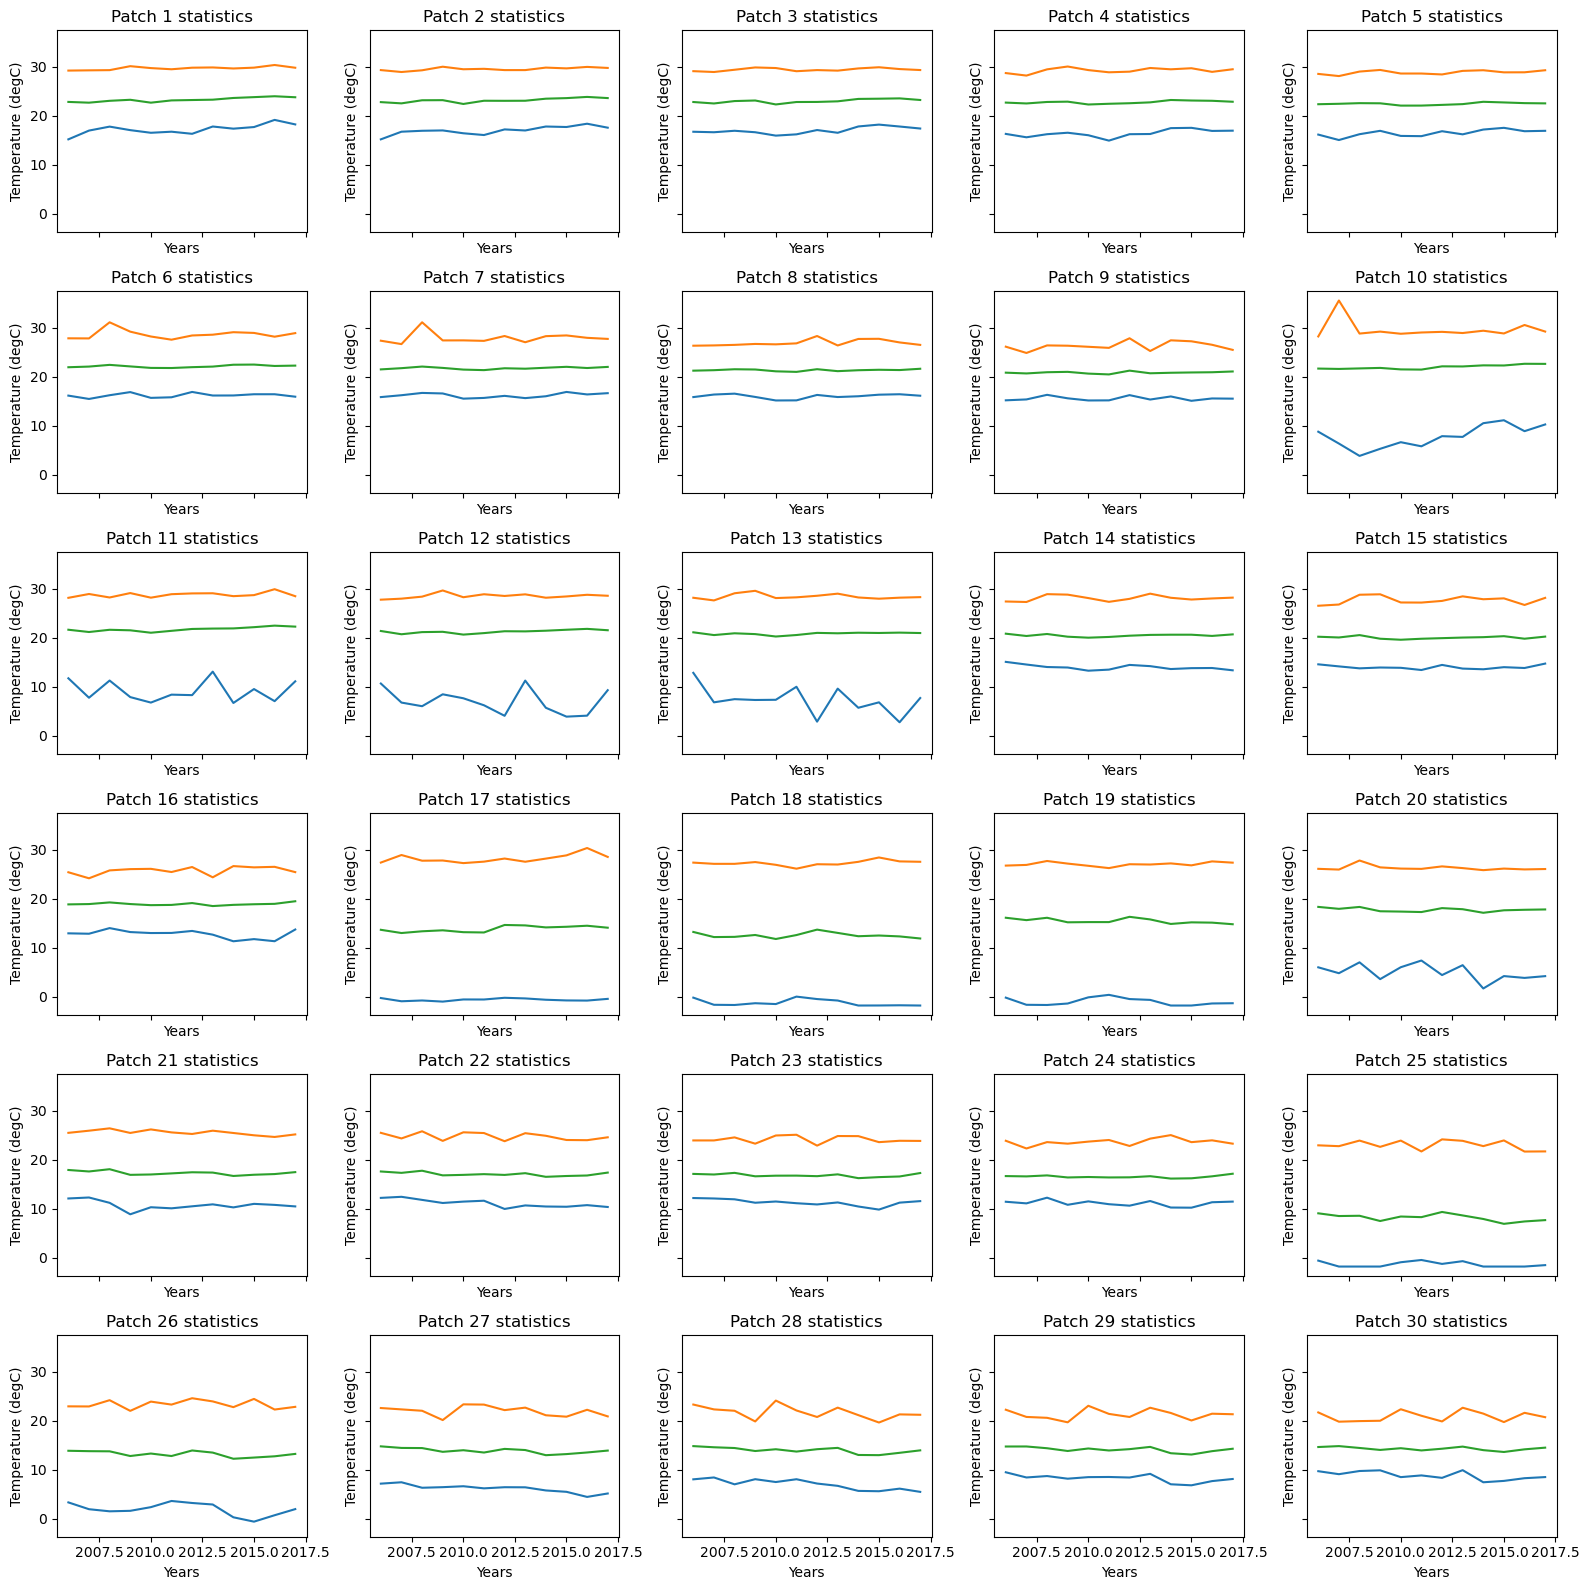

In [4]:
patches = list(range(1, 31))
years = list(range(2006, 2018))

fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(16, 16), sharex=True, sharey=True)
for patch_idx, ax in zip(patches, axes.flatten()):
    min_temps = []
    max_temps = []
    mean_temps = []

    for year in years:
        ds = PatchDataset(patch_idx, year)
        min_temps.append(min_temp(ds))
        max_temps.append(max_temp(ds))
        mean_temps.append(mean_temp(ds))

    # Plot the results.
    ax.set_title(f'Patch {patch_idx} statistics')
    ax.plot(years, min_temps, label='Min temperature')
    ax.plot(years, max_temps, label='Max temperature')
    ax.plot(years, mean_temps, label='Mean temperature')
    ax.set_xlabel('Years')
    ax.set_ylabel('Temperature (degC)')

fig.tight_layout()

## Temperature Variation with a year

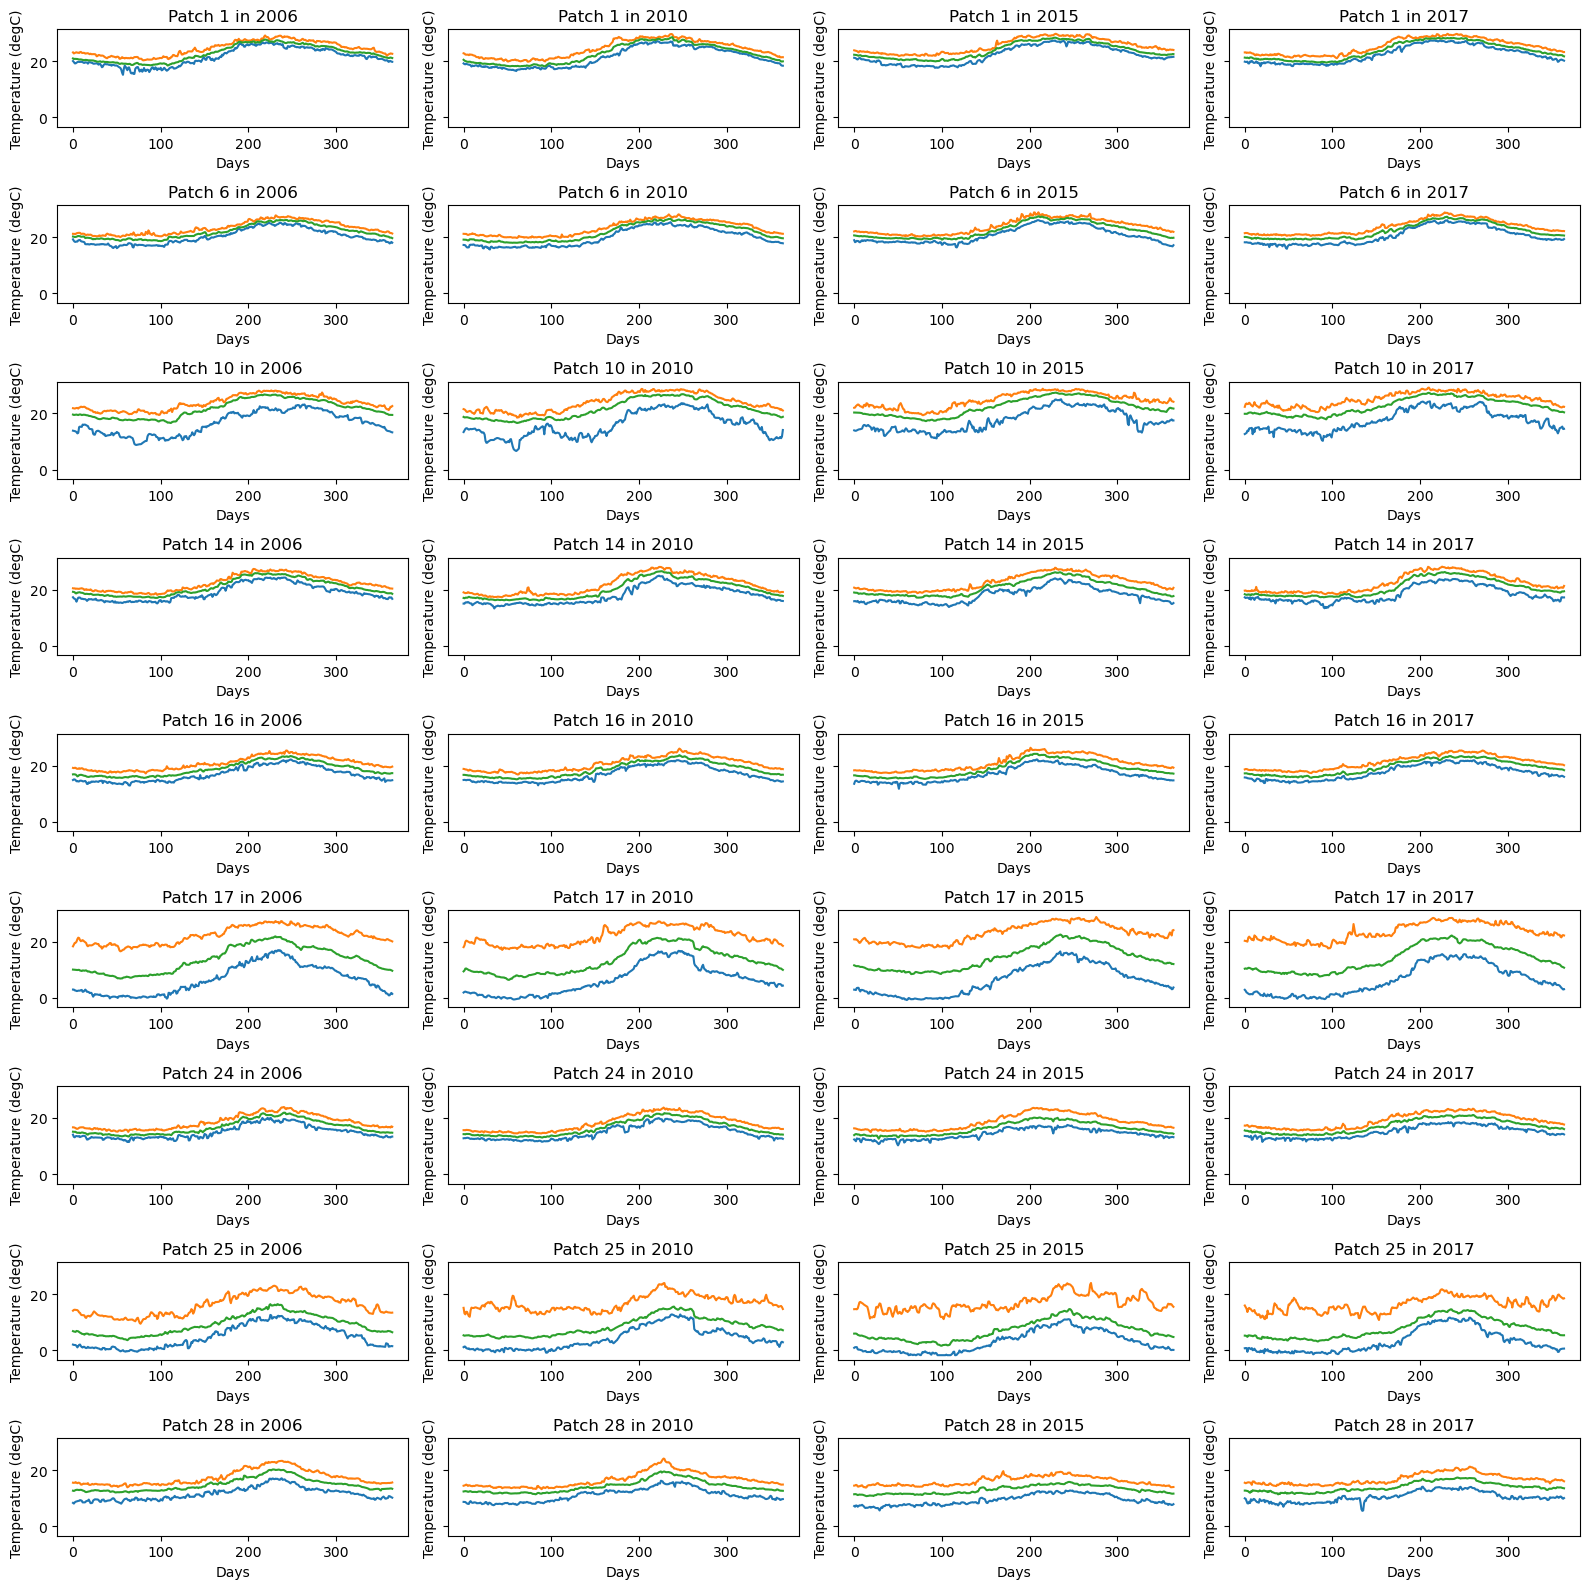

In [5]:
patches = [1, 6, 10, 14, 16, 17, 24, 25, 28]
years = [2006, 2010, 2015, 2017]
fig, axes = plt.subplots(ncols=len(years), nrows=len(patches), sharey=True, figsize=(16, 16))
for row, patch_idx in enumerate(patches):
    for col, year in enumerate(years):
        ax = axes[row, col]

        ds = PatchDataset(patch_idx, year)
        min_temps = [p.min() for p in ds]
        max_temps = [p.max() for p in ds]
        mean_temps = [p.mean() for p in ds]

        days = list(range(len(ds)))
        ax.plot(days, min_temps)
        ax.plot(days, max_temps)
        ax.plot(days, mean_temps)
        ax.set_title(f'Patch {patch_idx} in {year}')
        ax.set_xlabel('Days')
        ax.set_ylabel('Temperature (degC)')

fig.tight_layout()

## Temperature Variation in all years

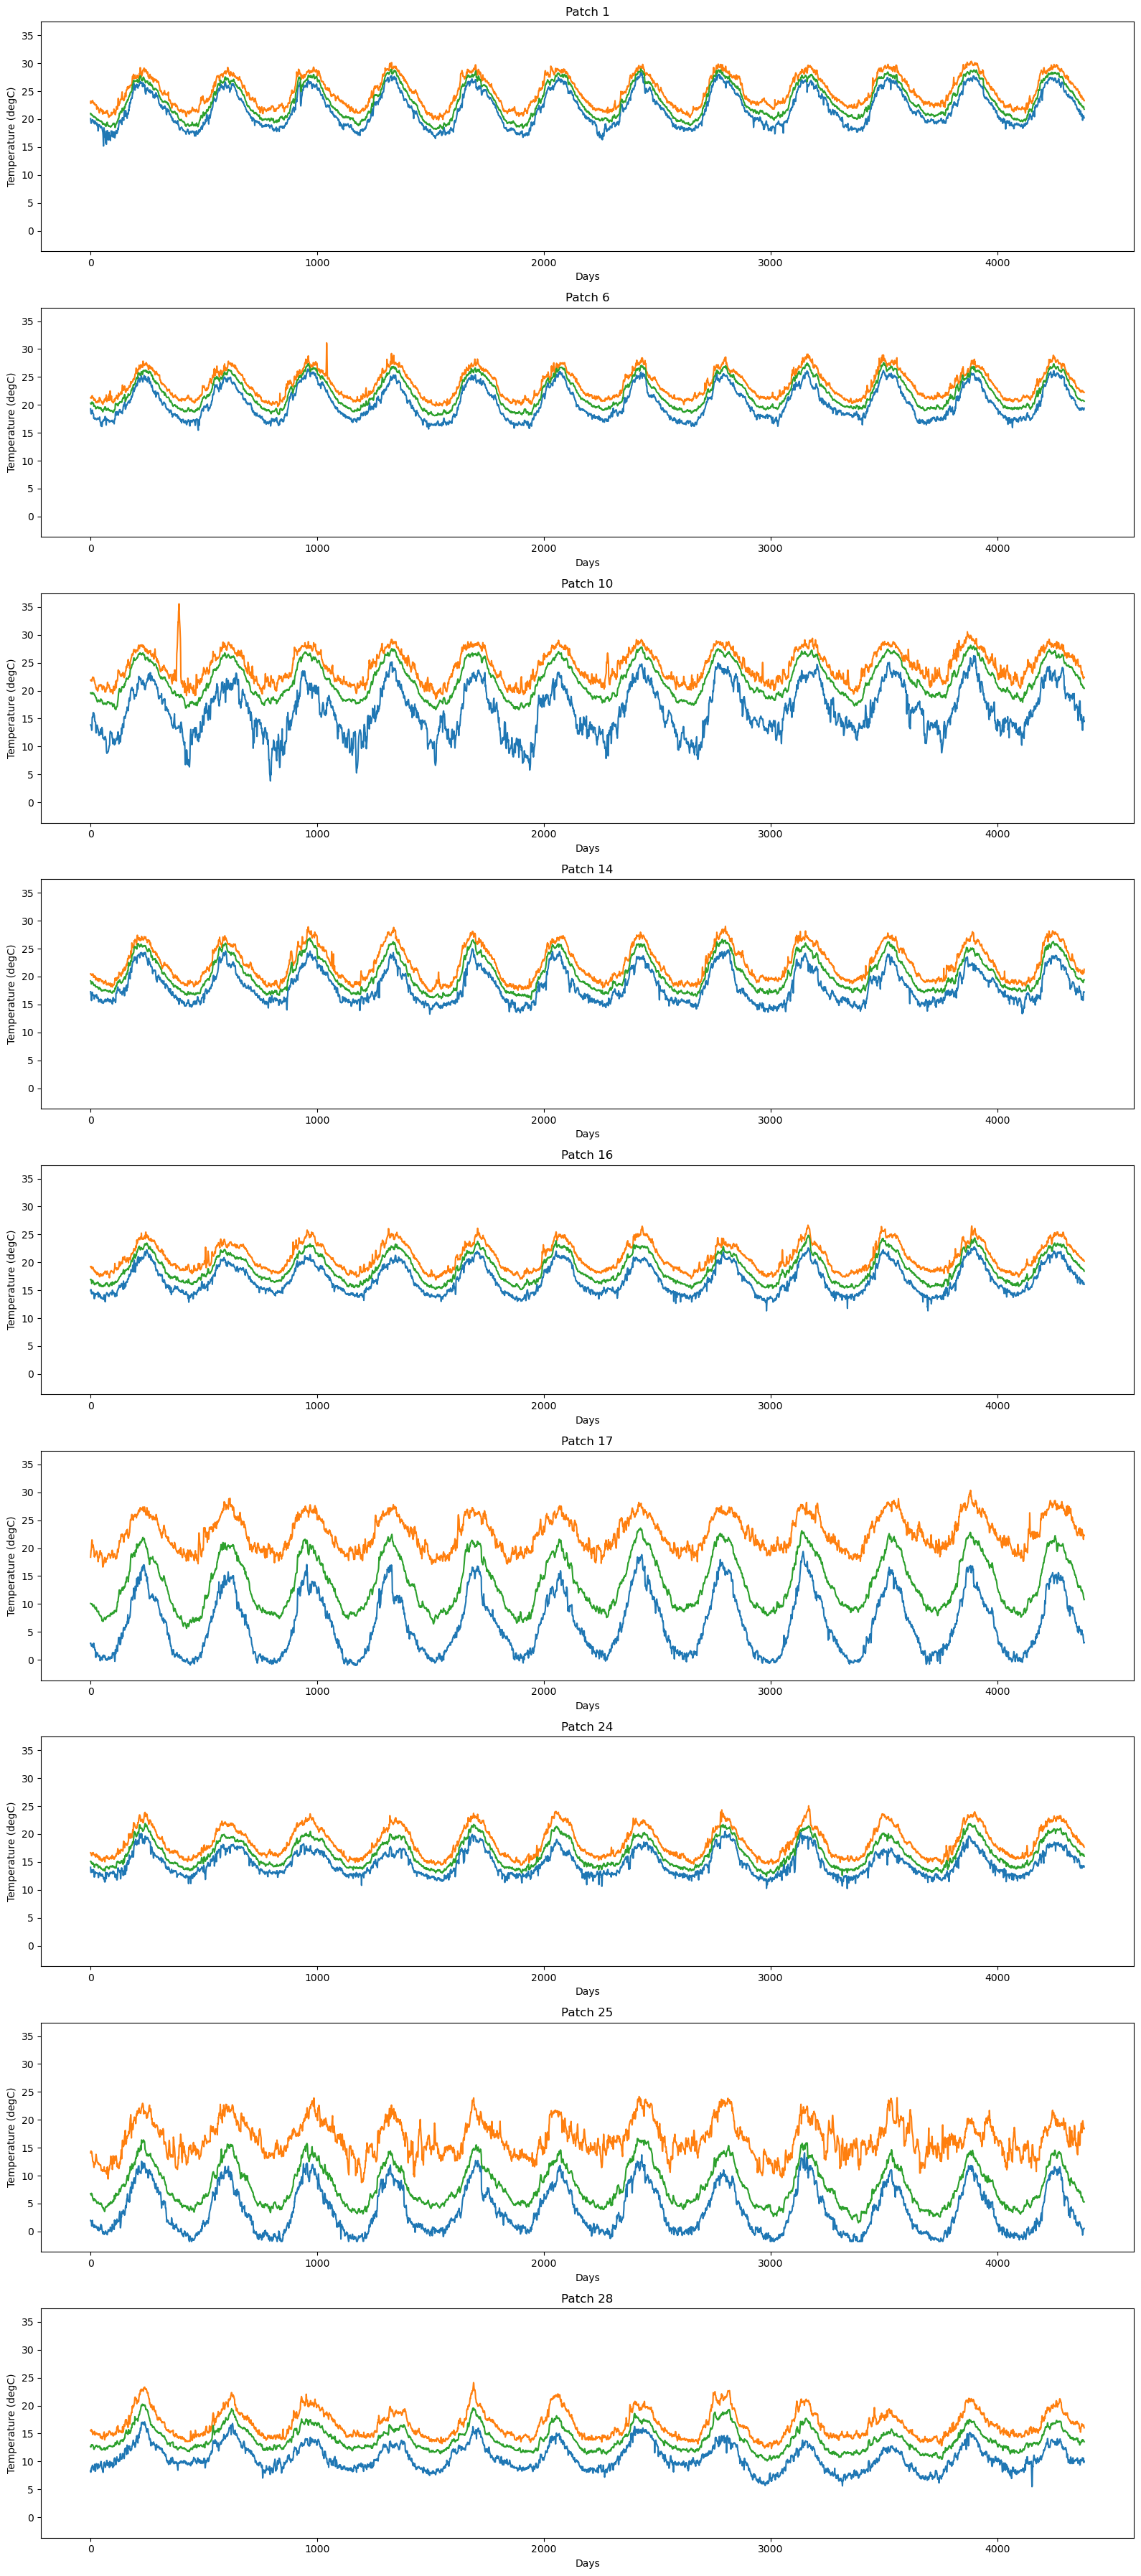

In [6]:
patches = [1, 6, 10, 14, 16, 17, 24, 25, 28]
fig, axes = plt.subplots(nrows=len(patches), sharey=True, figsize=(16, 4 * len(patches)))
for row, patch_idx in enumerate(patches):
    ax = axes[row]

    ds = PatchDataset(patch_idx)
    min_temps = [p.min() for p in ds]
    max_temps = [p.max() for p in ds]
    mean_temps = [p.mean() for p in ds]

    days = list(range(len(ds)))
    ax.plot(days, min_temps)
    ax.plot(days, max_temps)
    ax.plot(days, mean_temps)
    ax.set_title(f'Patch {patch_idx}')
    ax.set_xlabel('Days')
    ax.set_ylabel('Temperature (degC)')

fig.tight_layout()

## Temperature Difference Variation

In [7]:
class PatchDifferenceDataset(PatchDataset):
    def __init__(self, patch: int, year: int | None = None) -> None:
        super().__init__(patch, year)

    def _load_patches(self, path: int, year: int | None) -> np.ndarray:
        patches = super()._load_patches(path, year)
        diff = patches[1:] - patches[:-1]
        return diff


ds = PatchDataset(1, 2006)
diff_ds = PatchDifferenceDataset(1, 2006)
print(len(ds), len(diff_ds))

365 364


### Difference Statistics

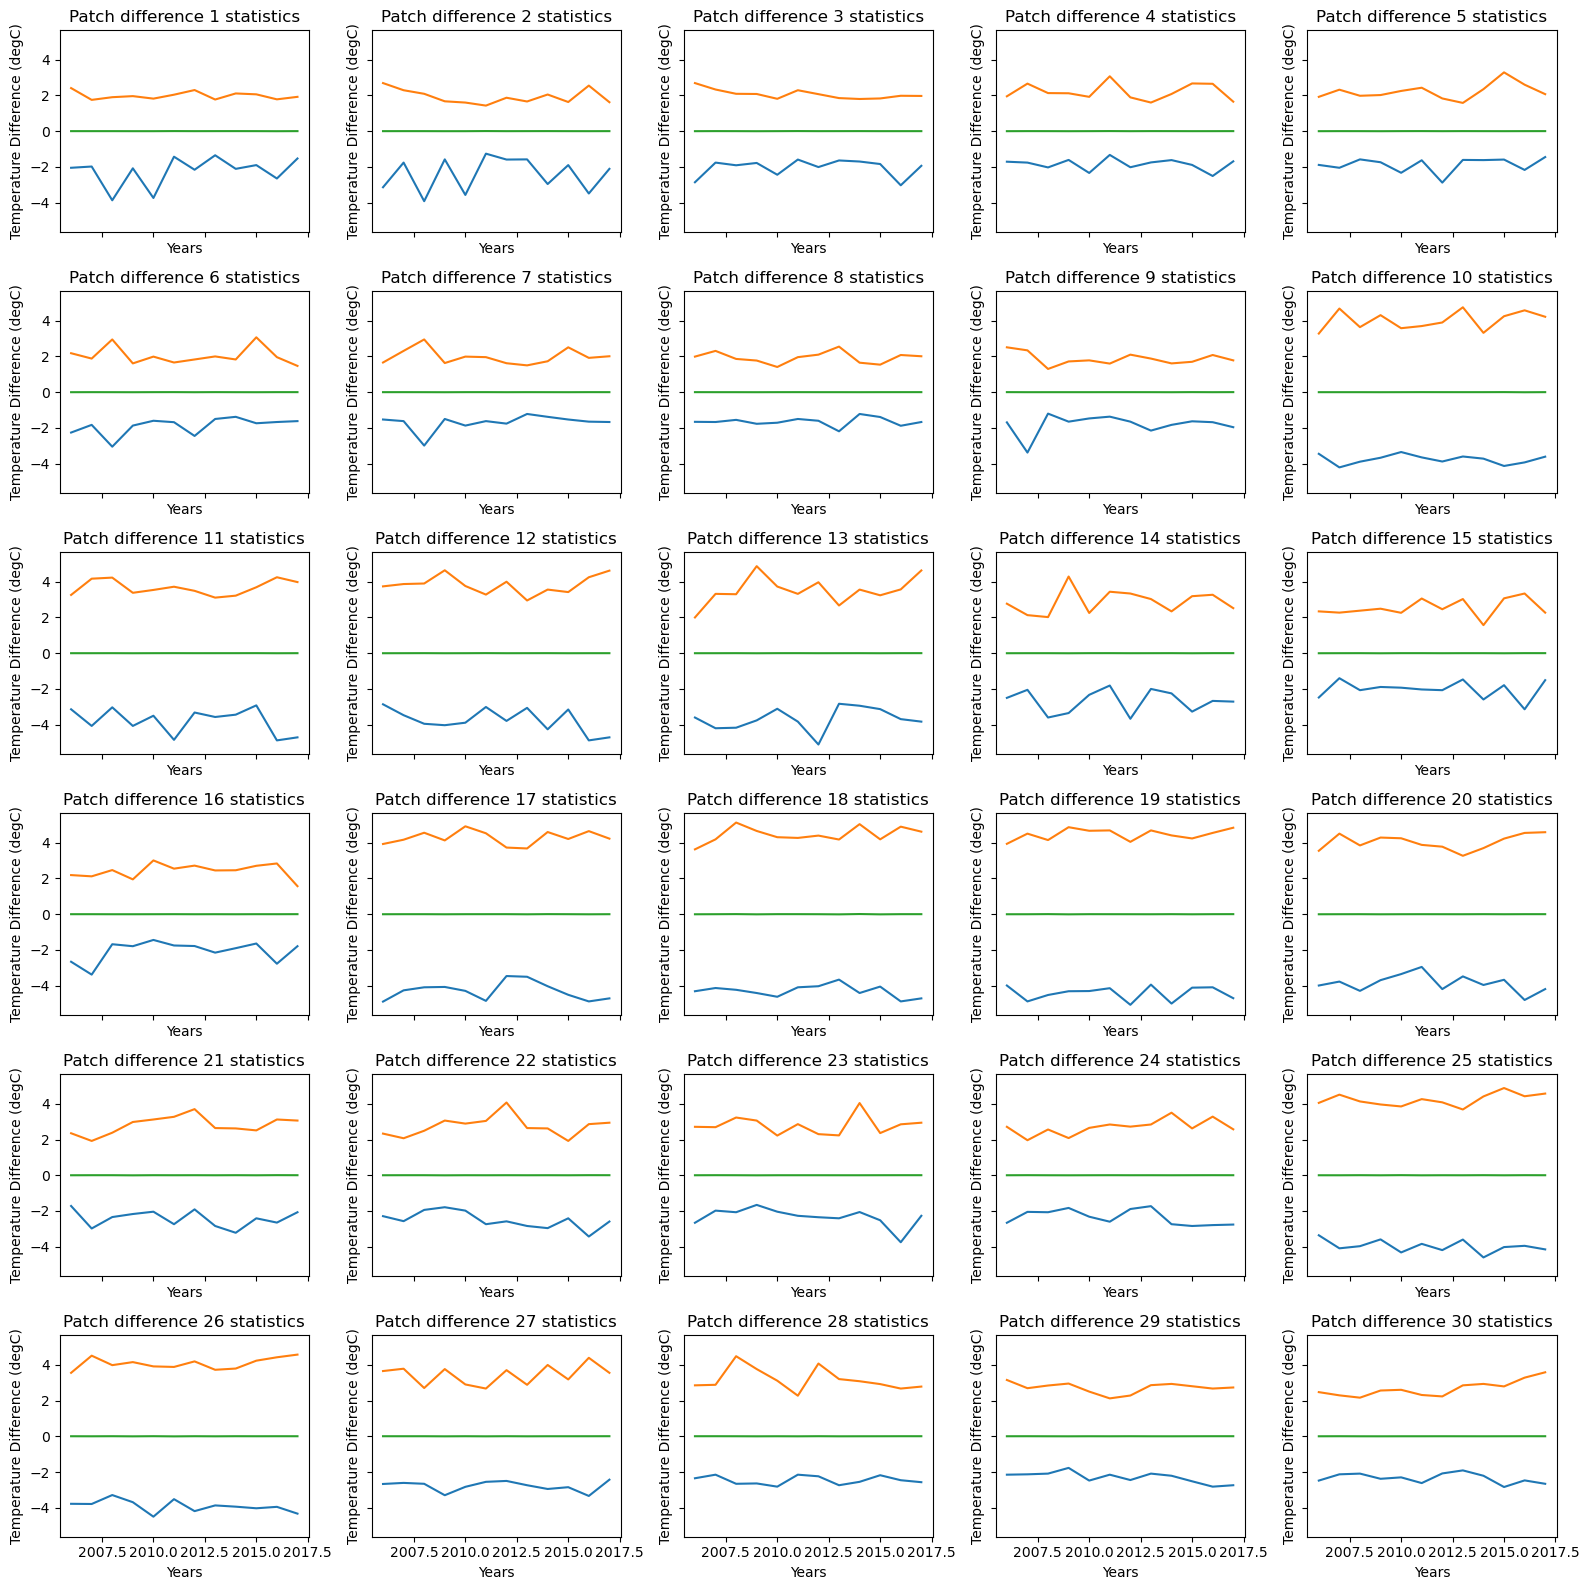

In [8]:
patches = list(range(1, 31))
years = list(range(2006, 2018))

fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(16, 16), sharex=True, sharey=True)
for patch_idx, ax in zip(patches, axes.flatten()):
    min_temps = []
    max_temps = []
    mean_temps = []

    for year in years:
        ds = PatchDifferenceDataset(patch_idx, year)
        min_temps.append(min_temp(ds))
        max_temps.append(max_temp(ds))
        mean_temps.append(mean_temp(ds))

    # Plot the results.
    ax.set_title(f'Patch difference {patch_idx} statistics')
    ax.plot(years, min_temps, label='Min difference')
    ax.plot(years, max_temps, label='Max difference')
    ax.plot(years, mean_temps, label='Mean difference')
    ax.set_xlabel('Years')
    ax.set_ylabel('Temperature Difference (degC)')

fig.tight_layout()

### Temperature Difference Variation within a year

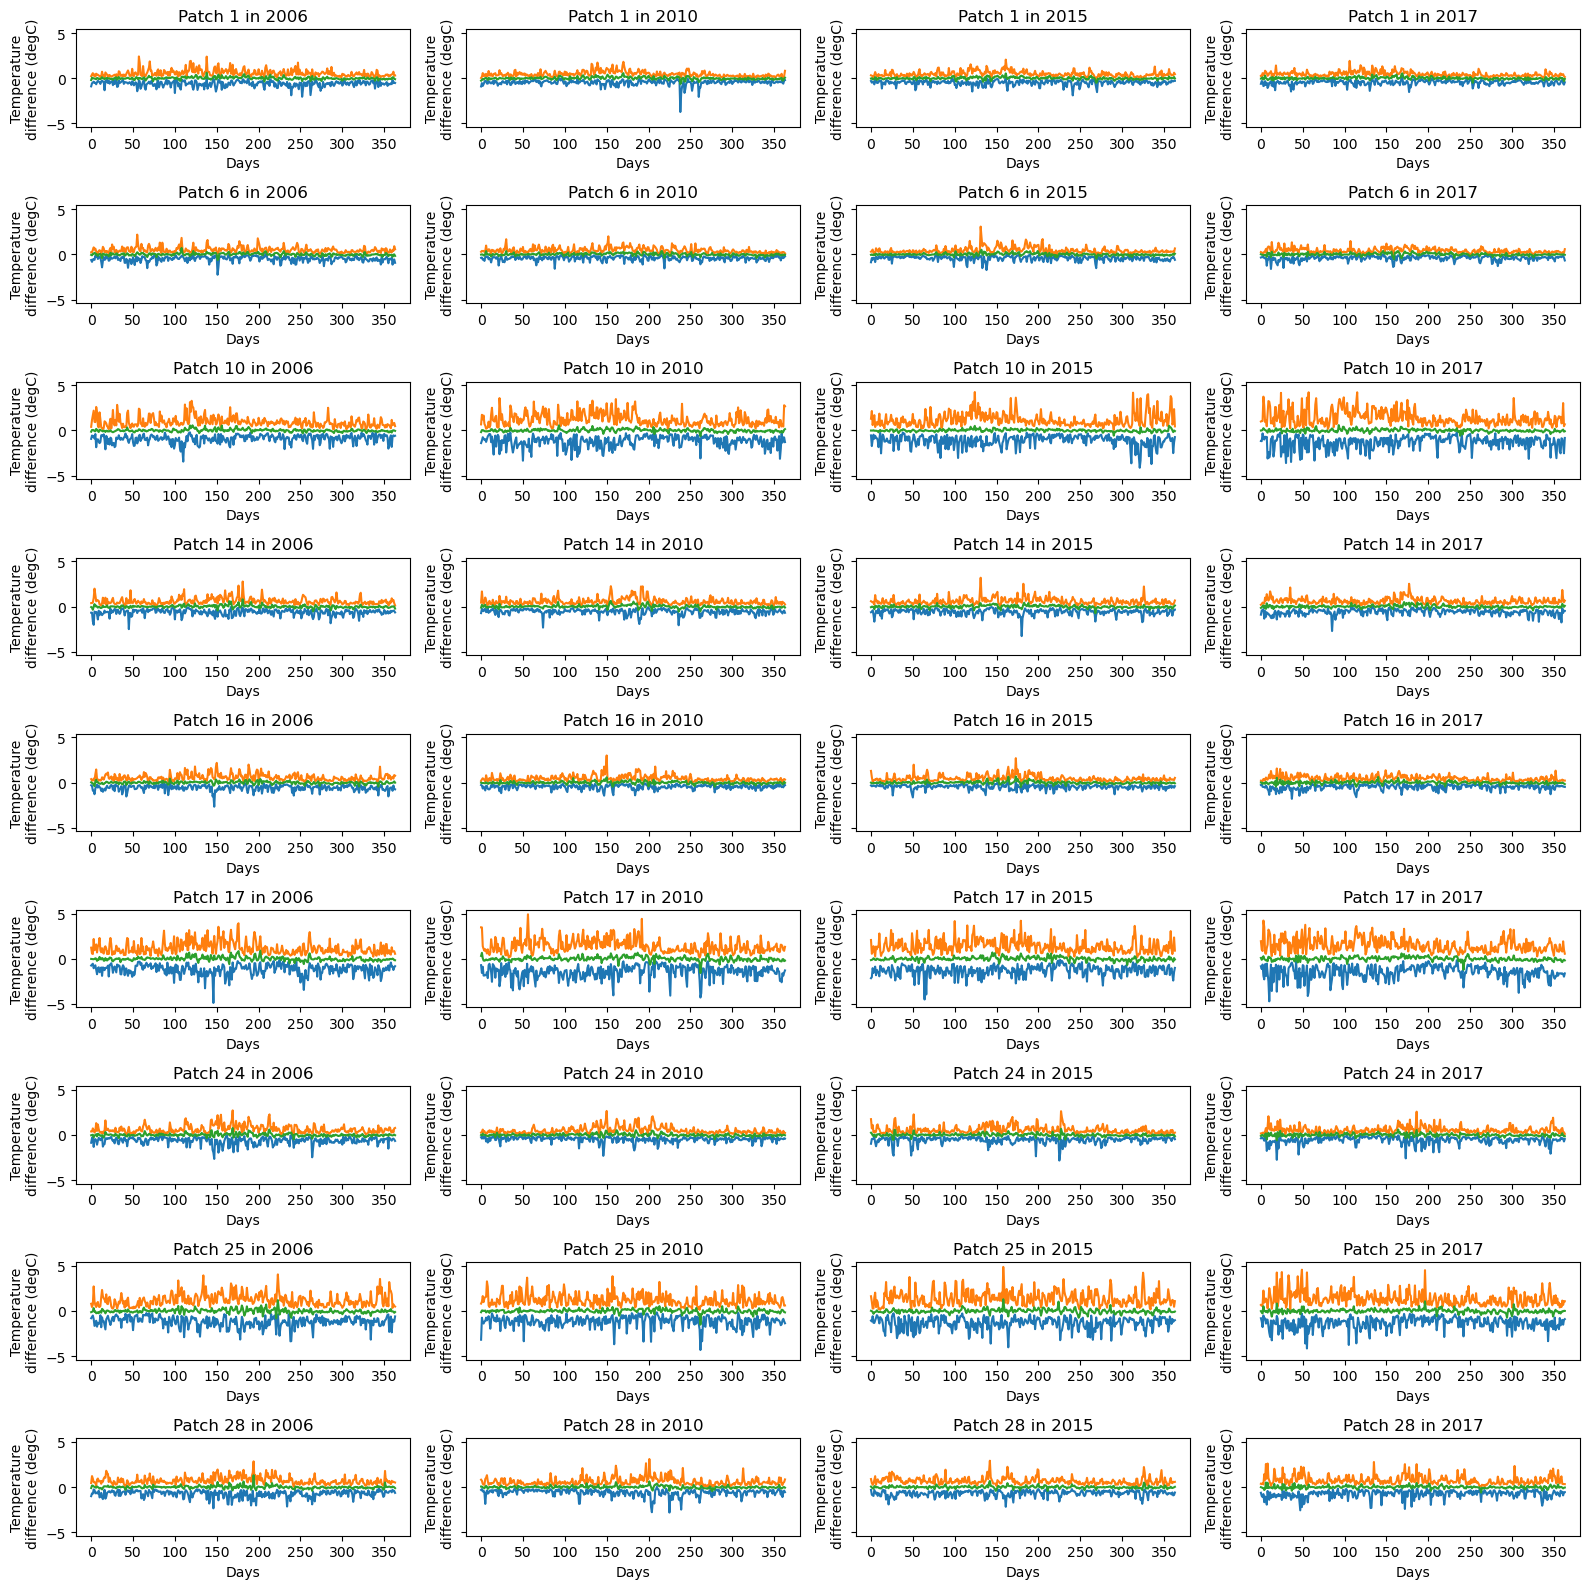

In [9]:
patches = [1, 6, 10, 14, 16, 17, 24, 25, 28]
years = [2006, 2010, 2015, 2017]
fig, axes = plt.subplots(ncols=len(years), nrows=len(patches), sharey=True, figsize=(16, 16))
for row, patch_idx in enumerate(patches):
    for col, year in enumerate(years):
        ax = axes[row, col]

        ds = PatchDifferenceDataset(patch_idx, year)
        min_temps = [p.min() for p in ds]
        max_temps = [p.max() for p in ds]
        mean_temps = [p.mean() for p in ds]

        days = list(range(len(ds)))
        ax.plot(days, min_temps)
        ax.plot(days, max_temps)
        ax.plot(days, mean_temps)
        ax.set_title(f'Patch {patch_idx} in {year}')
        ax.set_xlabel('Days')
        ax.set_ylabel('Temperature\ndifference (degC)')

fig.tight_layout()

### Temperature Difference Variation in all years

In [ ]:
patches = [1, 6, 10, 14, 16, 17, 24, 25, 28]
fig, axes = plt.subplots(nrows=len(patches), sharey=True, figsize=(16, 4 * len(patches)))
for row, patch_idx in enumerate(patches):
    ax = axes[row]

    ds = PatchDifferenceDataset(patch_idx)
    min_temps = [p.min() for p in ds]
    max_temps = [p.max() for p in ds]
    mean_temps = [p.mean() for p in ds]

    days = list(range(len(ds)))
    ax.plot(days, min_temps)
    ax.plot(days, max_temps)
    ax.plot(days, mean_temps)
    ax.set_title(f'Patch {patch_idx}')
    ax.set_xlabel('Days')
    ax.set_ylabel('Temperature\nDifference (degC)')

fig.tight_layout()

### Temperature Difference Std in all years

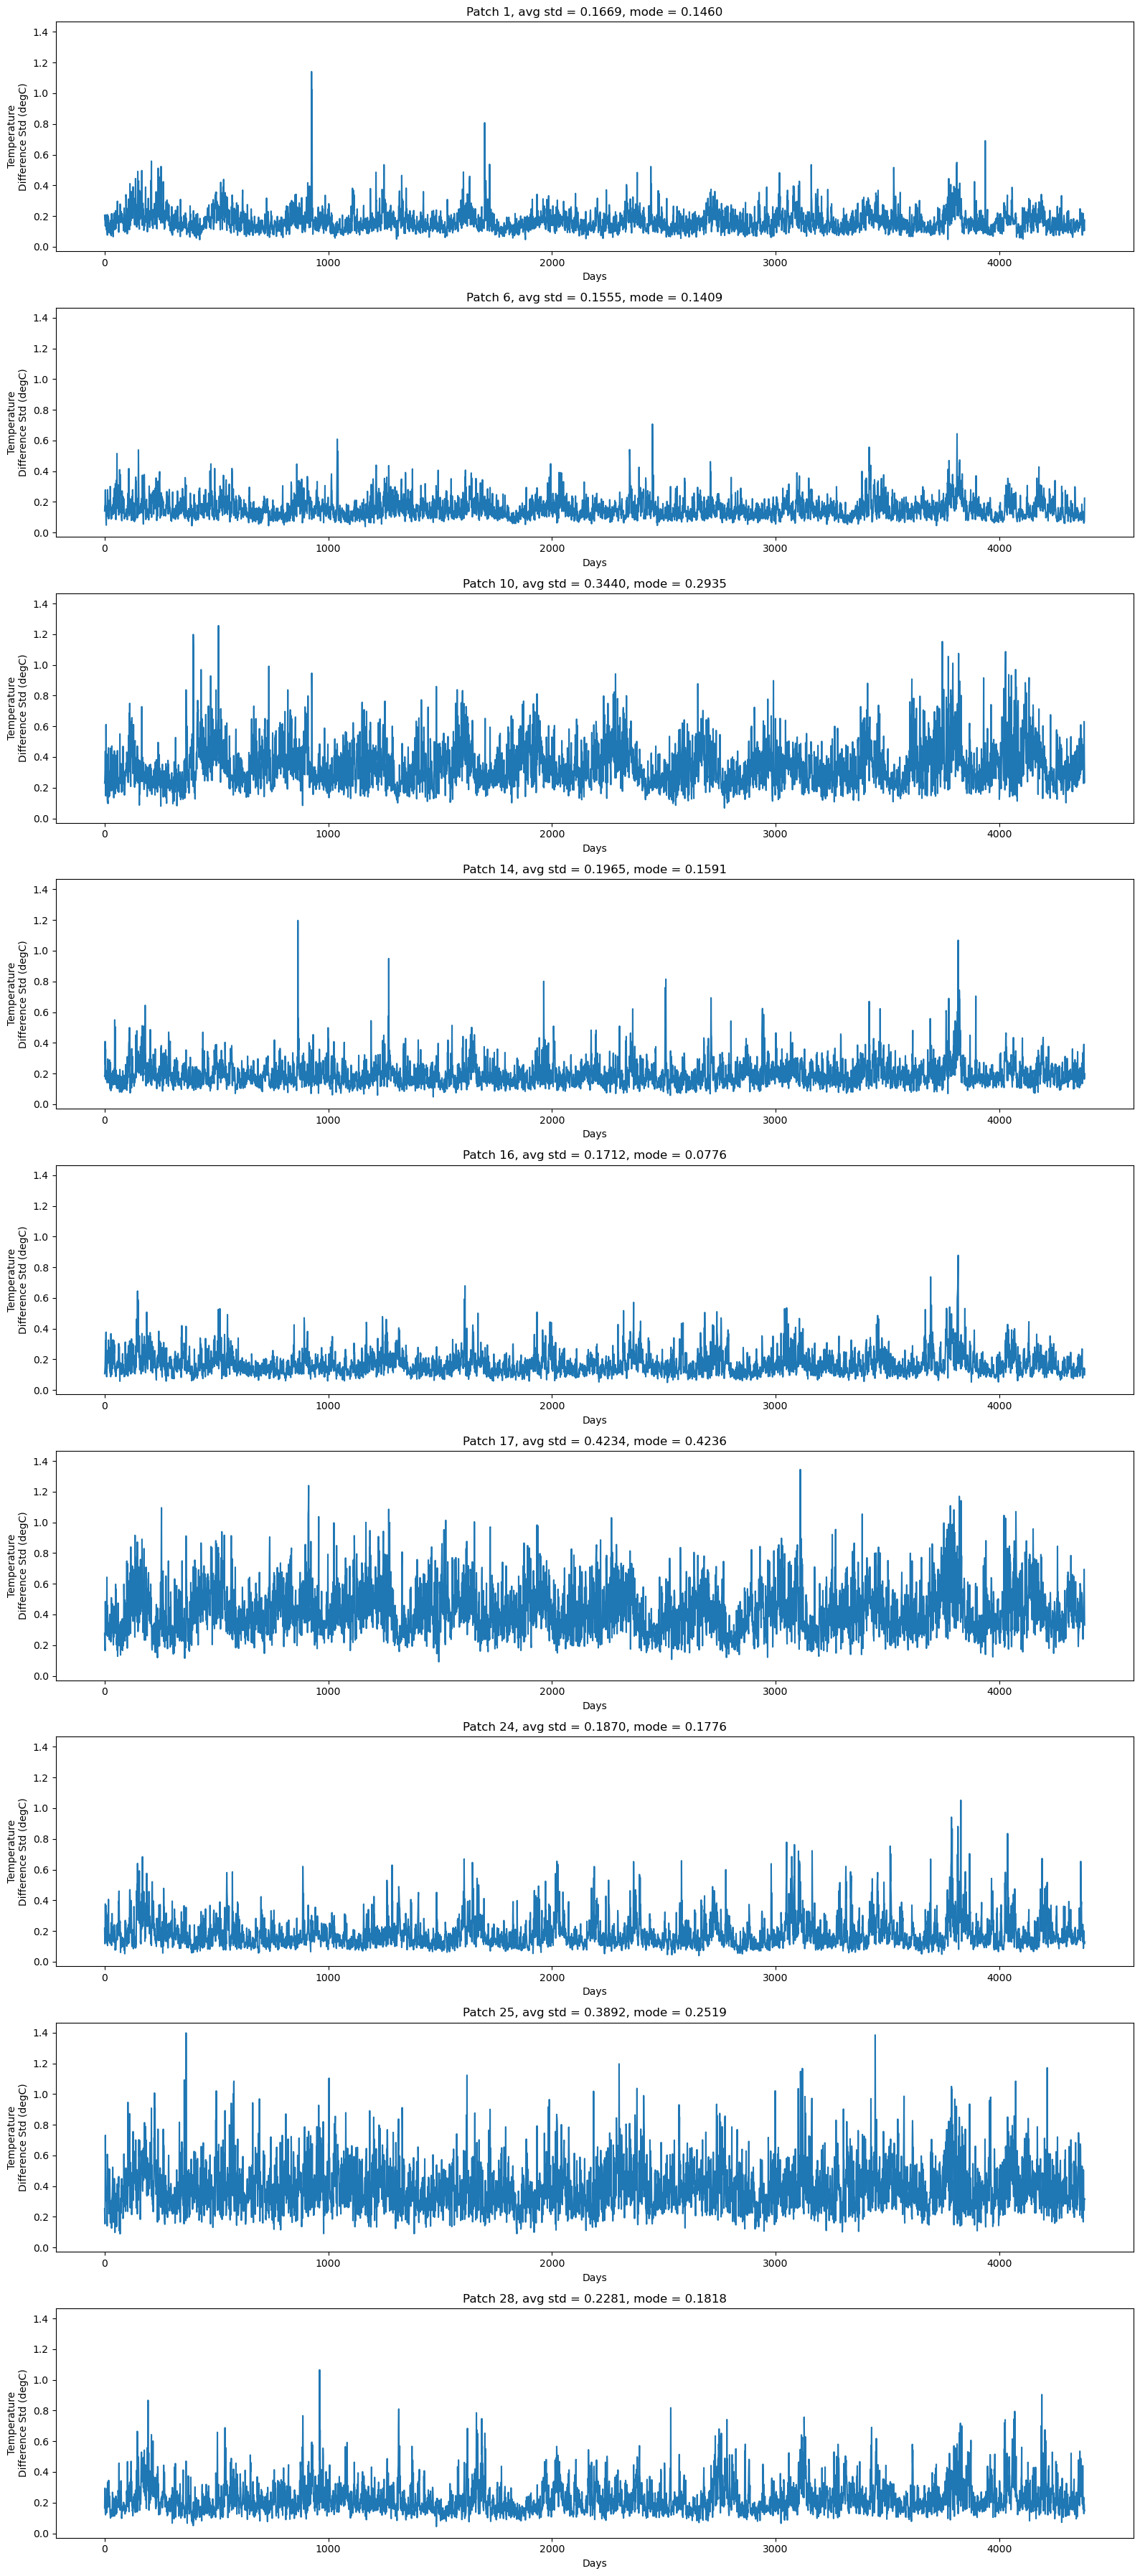

In [13]:
from statistics import mean, mode

patches = [1, 6, 10, 14, 16, 17, 24, 25, 28]
fig, axes = plt.subplots(nrows=len(patches), sharey=True, figsize=(16, 4 * len(patches)))
for row, patch_idx in enumerate(patches):
    ax = axes[row]

    ds = PatchDifferenceDataset(patch_idx)
    stds = [p.std() for p in ds]

    days = list(range(len(ds)))
    ax.plot(days, stds)
    ax.set_title(f'Patch {patch_idx}, avg std = {mean(stds):.4f}, mode = {mode(stds):.4f}')
    ax.set_xlabel('Days')
    ax.set_ylabel('Temperature\nDifference Std (degC)')

fig.tight_layout()